# GDS to Meep

It is often useful to simulate photonic devices before manufacturing them so that you have some idea of their performance. GDSFactory has a Meep plugin, Gmeep, that can be used to simulate devices using the finite-difference time-domain algorithm (FDTD).

There are several functions within Gmeep that can be used to take a component and turn it into a Meep geometry or simulation. This means that you can take any component, either from GDSFactory or from a GDS file (see the "component_from_gds" notebook), and easily turn it into a Meep geometry. The two most general functions are :py:func:`~gdsfactory.simulation.gmeep.get_simulation` and `get_meep_geometry_from_component` (contained within `gmeep.get_simulation.py`). There are other more specific functions to get simulations for a grating coupler with a fiber connected to it, as well as for a far-field simulation for a grating coupler. However, the first two will suffice in this tutorial. Below is some example code showing the use of the functions.

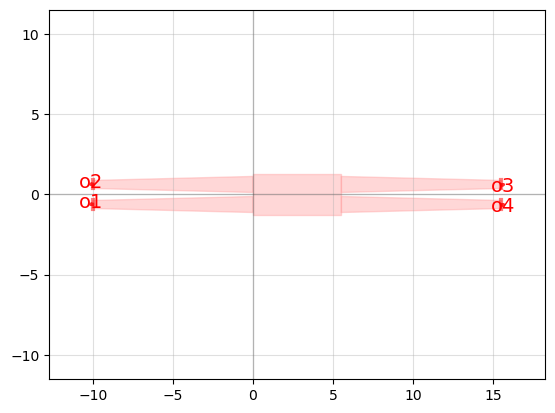

FloatProgress(value=0.0, description='0% done ', max=200.0)

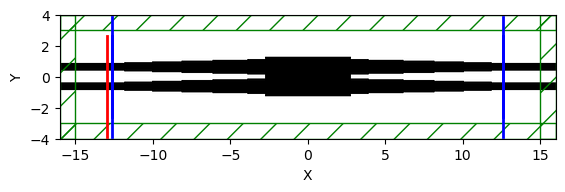

In [3]:
# Code showing examples with a 2x2 MMI for the functions in get_simulation

import gdsfactory as gf
import meep as mp
import tidy3d
from gdsfactory.simulation.gmeep.get_simulation import get_simulation, get_meep_geometry_from_component

# Load in the 2x2 MMI from GDSFactory and show layout
c = gf.components.mmi2x2()
c.plot()

# get_meep_geometry_from_component implementation example
get_meep_geometry_from_component(c)

# get_simulation implementation example
sim = get_simulation(component=c,
    resolution=20,
    tpml= 1,
    port_source_offset= 0.2,
    port_monitor_offset= -0.15,
    distance_source_to_monitors= 0.3,
)
sim['sim'].sources = sim['sources']
sim['sim'].cell_size.y = 8
sim['sim'].cell_size.x = 32

# Plot the simulataion set-up to see results of the function
sim['sim'].plot2D()

# You can the run the simulation with:
## sim['sim'].run(until=200)

### Finding S-parameters through gmeep

In addition to creating general simulations in Meep, there are several functions in GDSFactory that allow you to find the S-parameters (scattering parameters) of a given component. S-parameters are useful as they tell you how much light is coming in and out of each of the component's port. The most general function for this purpose in Gmeep is `write_sparameters_meep`. 

To use this function, you specify a GDSFactory component, the frequencies you want to test it at, if you would like the simulation to be in 3D, and the margins the simulation needs to take into account. Another useful kwarg for this function is "run". By setting this to `False`, the function plots the simulation geometry instead of running it. So, you can check that the geometry is correct before you waste time simulating it.This is especially important when running the simulation in 3D, as sometimes your geometry may be converted incorrectly from 2D.This is not a comprehensive list of the arguments and is only intended to give a general idea of how the function is used.

The function returns a dictionary of s-parameters. The keys take the form of `"o1@0,o2@0"`, where the first part of the key refers to what port the light is coming from and the second refers to where it is going. For however many ports you have in your component, there will be a key corresponding to the s-parameter from that port to every other port.

Since the relationship between some ports can be the same (i.e. the component may be symmetric), port symmetries can be specified as a keyword argument (kwarg) (`port_symmetries`). This argument takes a dictionary where you specify one s-parameter as the key, and assign as its values the other s-parameters that correspond to it. For example, if you had a 1x2 splitter, where the 2 output ports were symmetric and labeled ports 2 and 3, then you could assign:

```port_symmetries = {"o2@0,o1@0": ["o3@0,o1@0"]}```

 so that the s-parameter for port 2 to 1 will be computed, but the one for port 3 to 1 will not be and will be written with the s-parameter for port 2 to 1. Thus, you save on computation time.

In addition to this general function, Gmeep also has two functions that can be used to write the s-parameters using parallel processing. These are `write_sparamters_meep_mpi` and `write_sparameters_meep_batch`. `write_sparamters_meep_mpi` has you specify how many cores you want to use as a kwarg. `write_sparameters_meep_batch` takes it a step further and runs multiple simulations in parallel, instead of just one. So, you must specify the number of cores per run in addition to the total number of cores to use.

`write_sparameters_grating` is a more specific instance that can be used to find the s-parameters for a grating coupler with an attached fiber. To plot the set up of this, you can pass in the argument `plot=True`. There is also the option of writing the s-parameters for a grating coupler in parallel or in batches, with `write_sparameters_grating_mpi` and `write_sparameters_grating_batch`. Like the general s-parameter functions above, more kwargs are necessary to adequately define them.

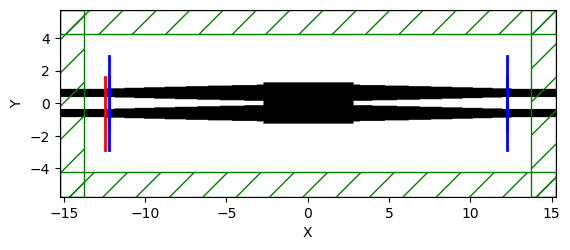

In [8]:
import gdsfactory as gf
import meep as mp
import gdsfactory.simulation.gmeep as gm
import tidy3d

c = gf.components.mmi2x2()

# Plot s-parameters simulation
gm.write_sparameters_meep(c, xmargin_left=1, xmargin_right=1, port_source_offset=-0.3, port_monitor_offset=-0.5, run=False)

# Run simulation and save results
sp = gm.write_sparameters_meep(c, xmargin_left=1, xmargin_right=1, port_source_offset=-0.3, port_monitor_offset=-0.5)

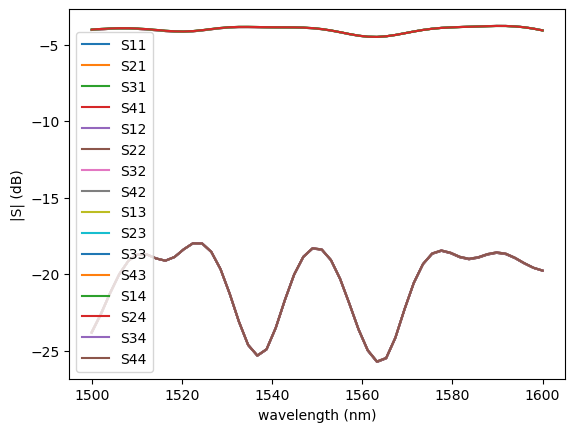

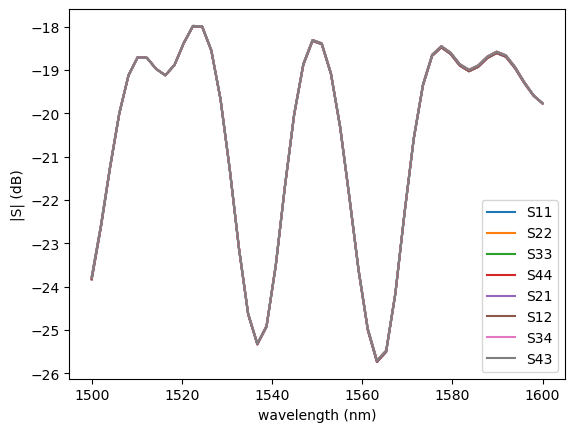

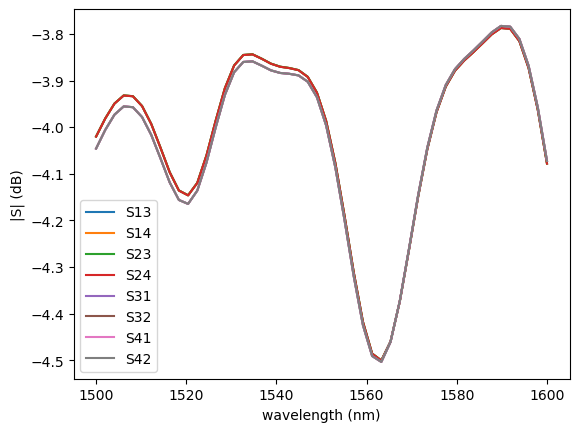

In [7]:
# Plot the s-parameters
gf.simulation.plot.plot_sparameters(sp)

# Plot just the s-parameters for reflections
gf.simulation.plot.plot_sparameters(sp, keys=("o1@0,o1@0",'o2@0,o2@0','o3@0,o3@0','o4@0,o4@0', 'o2@0,o1@0', 'o1@0,o2@0','o3@0,o4@0','o4@0,o3@0'))

# Plot just the s-parameters for incident waves
gf.simulation.plot.plot_sparameters(sp, keys=('o1@0,o3@0','o1@0,o4@0','o2@0,o3@0','o2@0,o4@0','o3@0,o1@0','o3@0,o2@0','o4@0,o1@0','o4@0,o2@0'))

As seen above, some of the port relationships have the same s-parameters. This means that there is some symmetry in the component. Which ports have the same relationships and why? Modify the code to include these port symmetries by passing in a dictionary to the `port_symmetries` kwarg for `write_sparameters_meep`. The dictionary should look like:

``
port_symmetries = {
    port name: [list port names that have the same s-parameters],
    another port: [another list of matching s-parameters]
}
``